In [19]:
using DrWatson; @quickactivate
include(srcdir("utils.jl"))

using CSV, DataFrames, DataFramesMeta
using StatsPlots
using Distributions

### Data import

Load [Kaggle dataset](https://www.kaggle.com/datasets/stefanoleone992/mutual-funds-and-etfs) of US mutual funds 

In [88]:
funds = CSV.read(datadir("kaggle-funds", "MutualFunds.csv"), DataFrame) 

allyears = ["fund_return_" * year for year in string.(collect(2000:2020))]
colnames = copy(allyears)
#insert!(colnames, 1, "fund_symbol")

returns = funds[:, colnames]
dropmissing!(returns)

3946×21 DataFrame
  Row │ fund_return_2000  fund_return_2001  fund_return_2002  fund_return_2003 ⋯
      │ Float64           Float64           Float64           Float64          ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │         -0.1436           -0.24329          -0.30137           0.2895  ⋯
    2 │         -0.03389          -0.07137          -0.12814           0.20376
    3 │          0.03314          -0.03016          -0.11361           0.14943
    4 │          0.10429           0.05348          -0.07562           0.23784
    5 │          0.10572           0.05587          -0.0749            0.24258 ⋯
    6 │          0.11438           0.02095          -0.15889           0.35755
    7 │         -0.14775          -0.11815          -0.32991           0.3516
    8 │          0.11223           0.01878          -0.16184           0.35354
  ⋮   │        ⋮                 ⋮                 ⋮                 ⋮         ⋱
 3940 │          0.039             0.02117          -0.04618           0.47771 ⋯
 3941 │         -0.02043          -0.2201           -0.18346           0.26069
 3942 │         -0.631             0.16531          -0.24651           0.33564
 3943 │         -0.51488          -0.09619          -0.2344            0.40114
 3944 │          0.05226           0.05029           0.05883           0.0522  ⋯
 3945 │          0.13462           0.19463           0.11414           0.3303
 3946 │          0.06602           0.17136           0.1499            0.31786
                                                17 columns and 3931 rows omitted

In [131]:
IRX = CSV.read(datadir("^IRX.csv"), DataFrame)
@transform!(IRX, :Year = Year.(:Date))

Rf = combine(groupby(IRX, :Year), :Close => mean => :IRX).IRX/100

21-element Vector{Float64}:
 0.05815000000000001
 0.032583333333333325
 0.015759999999999996
 0.009997500000000001
 0.014115833333333334
 0.03207666666666666
 0.047443333333333323
 0.04281666666666667
 0.012183333333333332
 0.001391666666666667
 ⋮
 0.0007624999999999999
 0.0004508333333333334
 0.00020416666666666665
 0.00042333333333333334
 0.00299
 0.0093825
 0.019422499999999995
 0.020019166666666668
 0.0030075000000000006

In [115]:
excess_returns = copy(returns)

for row in eachrow(excess_returns)
    row .= collect(row) .- Rf
end
excess_returns

3946×21 DataFrame
  Row │ fund_return_2000  fund_return_2001  fund_return_2002  fund_return_2003 ⋯
      │ Float64           Float64           Float64           Float64          ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │         -0.1959           -0.30039          -0.31837           0.27763 ⋯
    2 │         -0.08619          -0.12847          -0.14514           0.19189
    3 │         -0.01916          -0.08726          -0.13061           0.13756
    4 │          0.05199          -0.00362          -0.09262           0.22597
    5 │          0.05342          -0.00123          -0.0919            0.23071 ⋯
    6 │          0.06208          -0.03615          -0.17589           0.34568
    7 │         -0.20005          -0.17525          -0.34691           0.33973
    8 │          0.05993          -0.03832          -0.17884           0.34167
  ⋮   │        ⋮                 ⋮                 ⋮                 ⋮         ⋱
 3940 │         -0.0133           -0.03593          -0.06318           0.46584 ⋯
 3941 │         -0.07273          -0.2772           -0.20046           0.24882
 3942 │         -0.6833            0.10821          -0.26351           0.32377
 3943 │         -0.56718          -0.15329          -0.2514            0.38927
 3944 │         -4.0e-5           -0.00681           0.04183           0.04033 ⋯
 3945 │          0.08232           0.13753           0.09714           0.31843
 3946 │          0.01372           0.11426           0.1329            0.30599
                                                17 columns and 3931 rows omitted

### Sharpe ratio and past performance

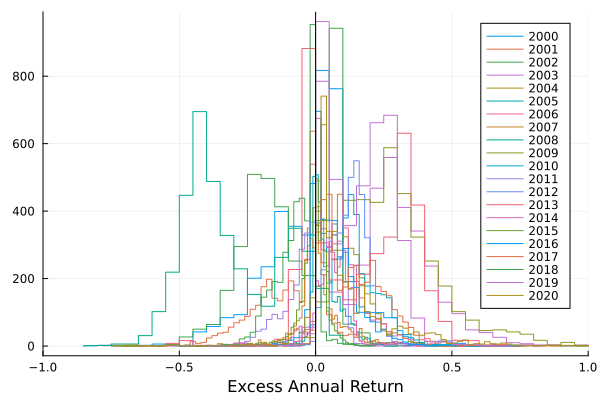

In [132]:
## Distribution of monthly returns 
p1 = plot(xlabel = "Excess Annual Return")
for year in 2000:2020
    plot!(excess_returns[:, "fund_return_" * string(year)],
    seriestype = :stephist, xlims = (-1, 1), label = string(year))
end
vline!([0], color = :black, label = false)

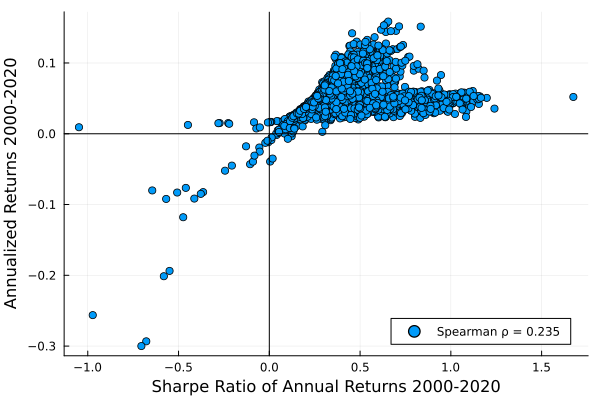

In [133]:
## Correlation between Sharpe ratio and annualized return?
s = mean.(eachrow(excess_returns[:, allyears]))./std.(eachrow(excess_returns[:, allyears]))
a = annualized_return.(eachrow(returns[:, allyears])) 



ρ = corspearman(s, a)
p2 = scatter(
    s,
    a,
    xlabel = "Sharpe Ratio of Annual Returns 2000-2020",
    ylabel = "Annualized Returns 2000-2020",
    label = "Spearman ρ = $(round(ρ; digits = 3))",
    legend = :bottomright
)
hline!([0], color = :black, label = false)
vline!([0], color = :black, label = false)

In [134]:
plot(p1, p2, size = (1000, 500), dpi = 500, plot_title="3946 US Funds (2000-2020)", layout = (1, 2))

savefig(plotsdir("funds"))

### Sharpe ratio and future performance

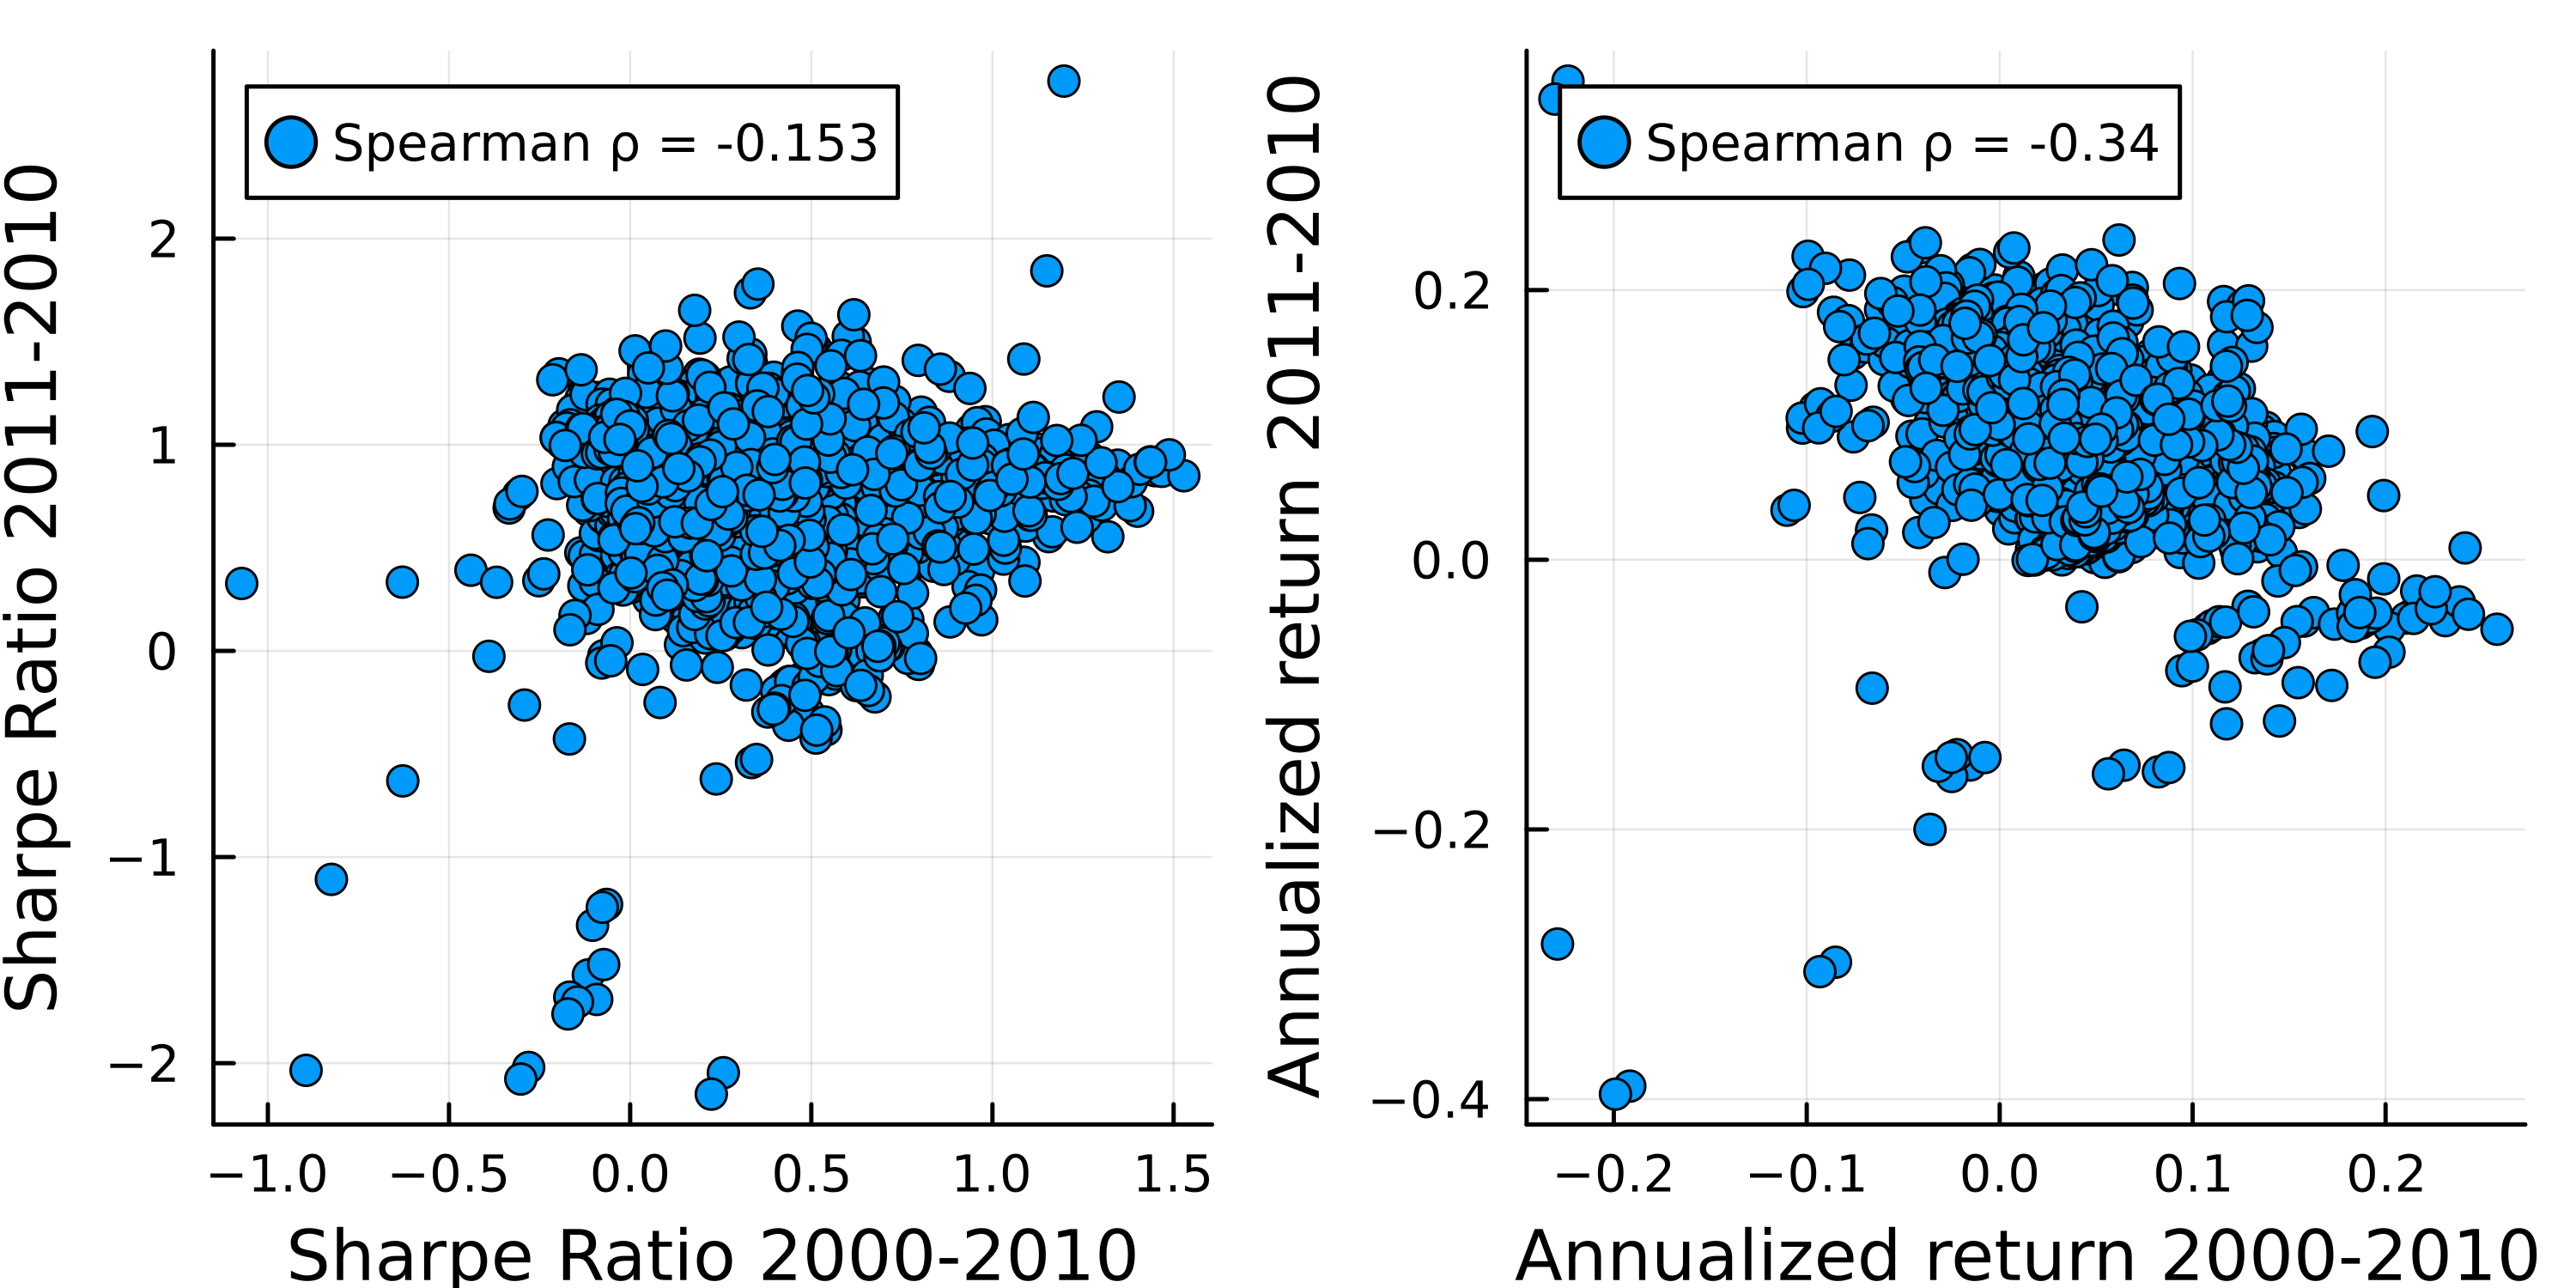

In [140]:
past = ["fund_return_" * year for year in string.(collect(2000:2010))]
future = ["fund_return_" * year for year in string.(collect(2011:2020))]

insample = sharpe.(eachrow(excess_returns[:, past]))
outsample = sharpe.(eachrow(excess_returns[:, future]))
ρ = corspearman(insample, outsample)

p1 = scatter(
    insample, 
    outsample, 
    label = "Spearman ρ = $(round(ρ; digits = 3))", 
    xlabel = "Sharpe Ratio 2000-2010", 
    ylabel = "Sharpe Ratio 2011-2010", 
    legend = :topleft
    )

insample = annualized_return.(eachrow(returns[:, past]))
outsample = annualized_return.(eachrow(returns[:, future]))
ρ = corspearman(insample, outsample)
    
p2 = scatter(
    insample, 
    outsample,
    label = "Spearman ρ = $(round(ρ; digits = 3))", 
    xlabel = "Annualized return 2000-2010", 
    ylabel = "Annualized return 2011-2010", 
    legend = :topleft
    )

plot(p1, p2, size = (600, 300), dpi = 500)